In [1]:
# @title Data Reading and processing
import pandas as pd
import os
from pandas import ExcelFile
import matplotlib.pyplot as plt
import seaborn as sns
from random import sample
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.multitest import multipletests
import warnings

gene_count_path ='/content/drive/MyDrive/MITResearch/IBD_13/gene.count.matrix.umi.csv'
metaphlan_path = ''
metadata_path = '/content/drive/MyDrive/MITResearch/IBD_13/sample.metadata.pass.tsv'

# Load gene count matrix
gene_count_df = pd.read_csv(gene_count_path)

# ---- Data Transformation Section ----
# Transpose gene count matrix to align with metaphlan_df data format
gene_count_df = gene_count_df.T

# Set the first row as column names and convert the matrix to a dataframe
new_col_names = gene_count_df.iloc[0]  # First row for column names
gene_count_df = gene_count_df[1:]  # Remove the first row
gene_count_df.columns = new_col_names  # Set new column names
gene_count_df.reset_index(drop=False,inplace=True)
gene_count_df.rename(columns={'index': 'PatientID_Weeknr'}, inplace=True)

meta = pd.read_csv(metadata_path, sep='\t')
meta.rename(columns={'label': 'PatientID_Weeknr'}, inplace=True)


print(f"Initial row count: {len(gene_count_df)}")

gene_count_df = pd.merge(gene_count_df, meta[['PatientID_Weeknr', 'patient', 'week']], how='left', on="PatientID_Weeknr")



print(f"New row count after merge: { len(gene_count_df)}")
cols = ['PatientID_Weeknr','patient', 'week'] + [col for col in gene_count_df.columns if col not in('PatientID_Weeknr','patient', 'week' )]
gene_count_df = gene_count_df[cols]
gene_count_df.rename(columns={'patient': 'patient_id'}, inplace=True)


gene_count_df['PatientID_Weeknr'] = gene_count_df['PatientID_Weeknr'].str.replace("ExfoSeqIBDtracker", "")

Initial row count: 605
New row count after merge: 605


In [2]:
meta

,PatientID_Weeknr,plate,patient,week,num_of_umi,num_of_reads
0,ExfoSeqIBDtrackerP7wA1,P7,TR_2101,Week_01,13492,132477
1,ExfoSeqIBDtrackerP7wB1,P7,TR_2101,Week_02,146537,491693
2,ExfoSeqIBDtrackerP7wC1,P7,TR_2101,Week_03,12783,66405
3,ExfoSeqIBDtrackerP7wD1,P7,TR_2101,Week_05,51919,256645
4,ExfoSeqIBDtrackerP7wE1,P7,TR_2101,Week_06,26024,49853
...,...,...,...,...,...,...
600,ExfoSeqIBDtrackerP5wD7,P5,TR_2205,Week_46,105989,1089803
601,ExfoSeqIBDtrackerP5wE7,P5,TR_2205,Week_47,230392,375509
602,ExfoSeqIBDtrackerP5wF7,P5,TR_2205,Week_48,358410,1016198
603,ExfoSeqIBDtrackerP5wG7,P5,TR_2205,Week_49,499432,1039398


In [ ]:
pattern = r'^P\d+w[A-Z]\d+$'

# Check which rows match this pattern
matches = gene_count_df['PatientID_Weeknr'].str.match(pattern)

# Print non-matching values
non_matching_values = gene_count_df.loc[~matches, 'PatientID_Weeknr']
if not non_matching_values.empty:
    print("Values not matching the expected format:")
    print(non_matching_values)
else:
    print("All values match the expected format.")

gene_count_df = gene_count_df[gene_count_df['PatientID_Weeknr'].str.match(pattern)]

gene_count_df['week'] = gene_count_df['week'].str.extract('Week_(\d+)').astype(int)

All values match the expected format.


In [ ]:
gene_count_df

,PatientID_Weeknr,patient_id,week,ABCA1_ENSG00000165029_ENST00000678995,ABCA8_ENSG00000141338_ENST00000586539,ABCB1_ENSG00000085563_ENST00000622132,ACKR3_ENSG00000144476_ENST00000272928,ACTB_ENSG00000075624_ENST00000674681,ACVR1B_ENSG00000135503_ENST00000257963,ACVR2A_ENSG00000121989_ENST00000241416,...,IFNL1_ENSG00000182393_ENST00000333625,IL2_ENSG00000109471_ENST00000226730,IL9_ENSG00000145839_ENST00000274520,IRGM_ENSG00000237693_ENST00000522154,KDR_ENSG00000128052_ENST00000263923,LCN2_ENSG00000148346_ENST00000373017,MUC19_ENSG00000205592_ENST00000454784,NLRP7_ENSG00000167634_ENST00000588756,ORMDL3_ENSG00000172057_ENST00000394169,TSLP_ENSG00000145777_ENST00000344895
0,P7wA1,TR_2101,1,2,0,389,1,1,5,0,...,0,0,0,0,0,0,0,0,0,0
1,P7wB1,TR_2101,2,99,0,312,1,13,73,1,...,0,0,0,0,0,0,0,0,0,0
2,P7wC1,TR_2101,3,3,0,13,1,0,5,10,...,0,0,0,0,0,0,0,0,0,0
3,P7wD1,TR_2101,5,145,0,112,0,0,16,0,...,0,0,0,0,0,0,0,0,0,0
4,P7wE1,TR_2101,6,4,0,47,1,0,5,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
600,P5wD7,TR_2205,46,138,0,70,36,1,4,0,...,0,0,0,0,0,0,0,0,0,0
601,P5wE7,TR_2205,47,1,0,350,3,4,26,2,...,0,0,0,0,0,0,0,0,0,0
602,P5wF7,TR_2205,48,123,0,160,9,40,61,32,...,0,0,0,0,0,0,0,0,0,0
603,P5wG7,TR_2205,49,160,0,749,3,9,199,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
#metaphlan_df = pd.read_csv(metaphlan_path, sep='\t')
#metaphlan_df['PatientID_Weeknr'] = metaphlan_df['PatientID_Weeknr'].str.replace("ExfoSeqIBDtracker", "")

In [ ]:
# @title Split 'PatientID_Weeknr' in patient id and week

def split_and_insert(df, column_name, split_str):
    df[column_name] = df[column_name].astype(str)
    patient_id, week = df[column_name].str.split(split_str, expand=True)[0], df[column_name].str.extract('(\d+)$')[0].astype(int)
    df.insert(0, 'week', week)
    df.insert(0, 'patient_id', patient_id)
    df.drop(column_name, axis=1, inplace=True)
    return df

#metaphlan_df = split_and_insert(metaphlan_df, 'PatientID_Weeknr', '__')
#gene_count_df = split_and_insert(gene_count_df, 'PatientID_Weeknr', '__')

#metaphlan_df = metaphlan_df.drop(['SampleName', 'Weeknumber', 'Exacerbation_judgement_treatingphysician'], axis=1)


In [ ]:
print(gene_count_df.shape)
#print(metaphlan_df.shape)

(605, 546)


In [ ]:
# @title merge metaphlan with gene_count to get the Flare_satus
#gene_count_df = pd.merge(gene_count_df, metaphlan_df[['patient_id', 'week', 'Flare_status']], on=['patient_id', 'week'], how='left')
#cols = ['Flare_status'] + [col for col in gene_count_df.columns if col != 'Flare_status']
#gene_count_df = gene_count_df[cols]


gene_count_df.sort_values(by=['patient_id', 'week'], inplace=True)

# Step 3: Fill missing 'Flare_status' values using forward fill
#gene_count_df['Flare_status'] = gene_count_df['Flare_status'].fillna(method='ffill')


In [ ]:
# @title Normalizing to housekeeping genes
# Define columns that should not be converted to numeric and normalized
exclude_columns = ['Flare_status', 'patient_id', 'week']

# Convert all other data in DataFrame to numeric types
for column in gene_count_df.columns:
    if column not in exclude_columns:
        gene_count_df[column] = pd.to_numeric(gene_count_df[column], errors='coerce')

# Define your housekeeping gene symbols
house_keeping_genes = ["ACTB", "ATP5F1", "B2M", "GAPDH", "GUSB",
                       "HPRT", "PGK1", "PPIA", "RPS18", "TBP",
                       "TFRC", "YWHAZ"]

# Find columns that start with any of the housekeeping gene symbols and are not in the excluded list
hk_gene_cols = [col for col in gene_count_df.columns
                if any(col.startswith(hk + '_') for hk in house_keeping_genes) and col not in exclude_columns]

# Selecting housekeeping genes data
hk_genes_data = gene_count_df[hk_gene_cols]

# Calculate the geometric mean of the housekeeping genes for each sample
# Adding a small value (e.g., 1e-9) to avoid taking log(0)
geometric_mean_hk = np.exp(np.log(hk_genes_data + 1e-9).mean(axis=1))

# Normalize the entire gene count matrix by the geometric mean of the housekeeping genes
# Apply normalization only to numeric columns
for column in gene_count_df.columns:
    if column not in exclude_columns:
        gene_count_df[column] = gene_count_df[column].div(geometric_mean_hk, axis=0)

# The DataFrame now contains normalized data for numeric columns, excluding specified non-numeric columns.


In [ ]:
# # @title
# # Calculate mean and standard deviation for each bacterial taxa
# bacteria_mean = metaphlan_df.iloc[:, 4:].mean()
# bacteria_std = metaphlan_df.iloc[:, 4:].std()

# # Identify the most represented bacteria (highest mean)
# most_represented_bacteria = bacteria_mean.sort_values(ascending=False).head(10)

# # Identify bacteria with the most variation (highest standard deviation)
# most_variable_bacteria = bacteria_std.sort_values(ascending=False).head(10)

# # Plotting
# plt.figure(figsize=(20, 10))

# plt.subplot(1, 2, 1)
# sns.barplot(x=most_represented_bacteria.values, y=most_represented_bacteria.index)
# plt.title('Top 10 Most Represented Bacteria')
# plt.xlabel('Mean Relative Abundance')

# plt.subplot(1, 2, 2)
# sns.barplot(x=most_variable_bacteria.values, y=most_variable_bacteria.index)
# plt.title('Top 10 Bacteria with Most Variation')
# plt.xlabel('Standard Deviation of Relative Abundance')

# plt.tight_layout()
# plt.show()


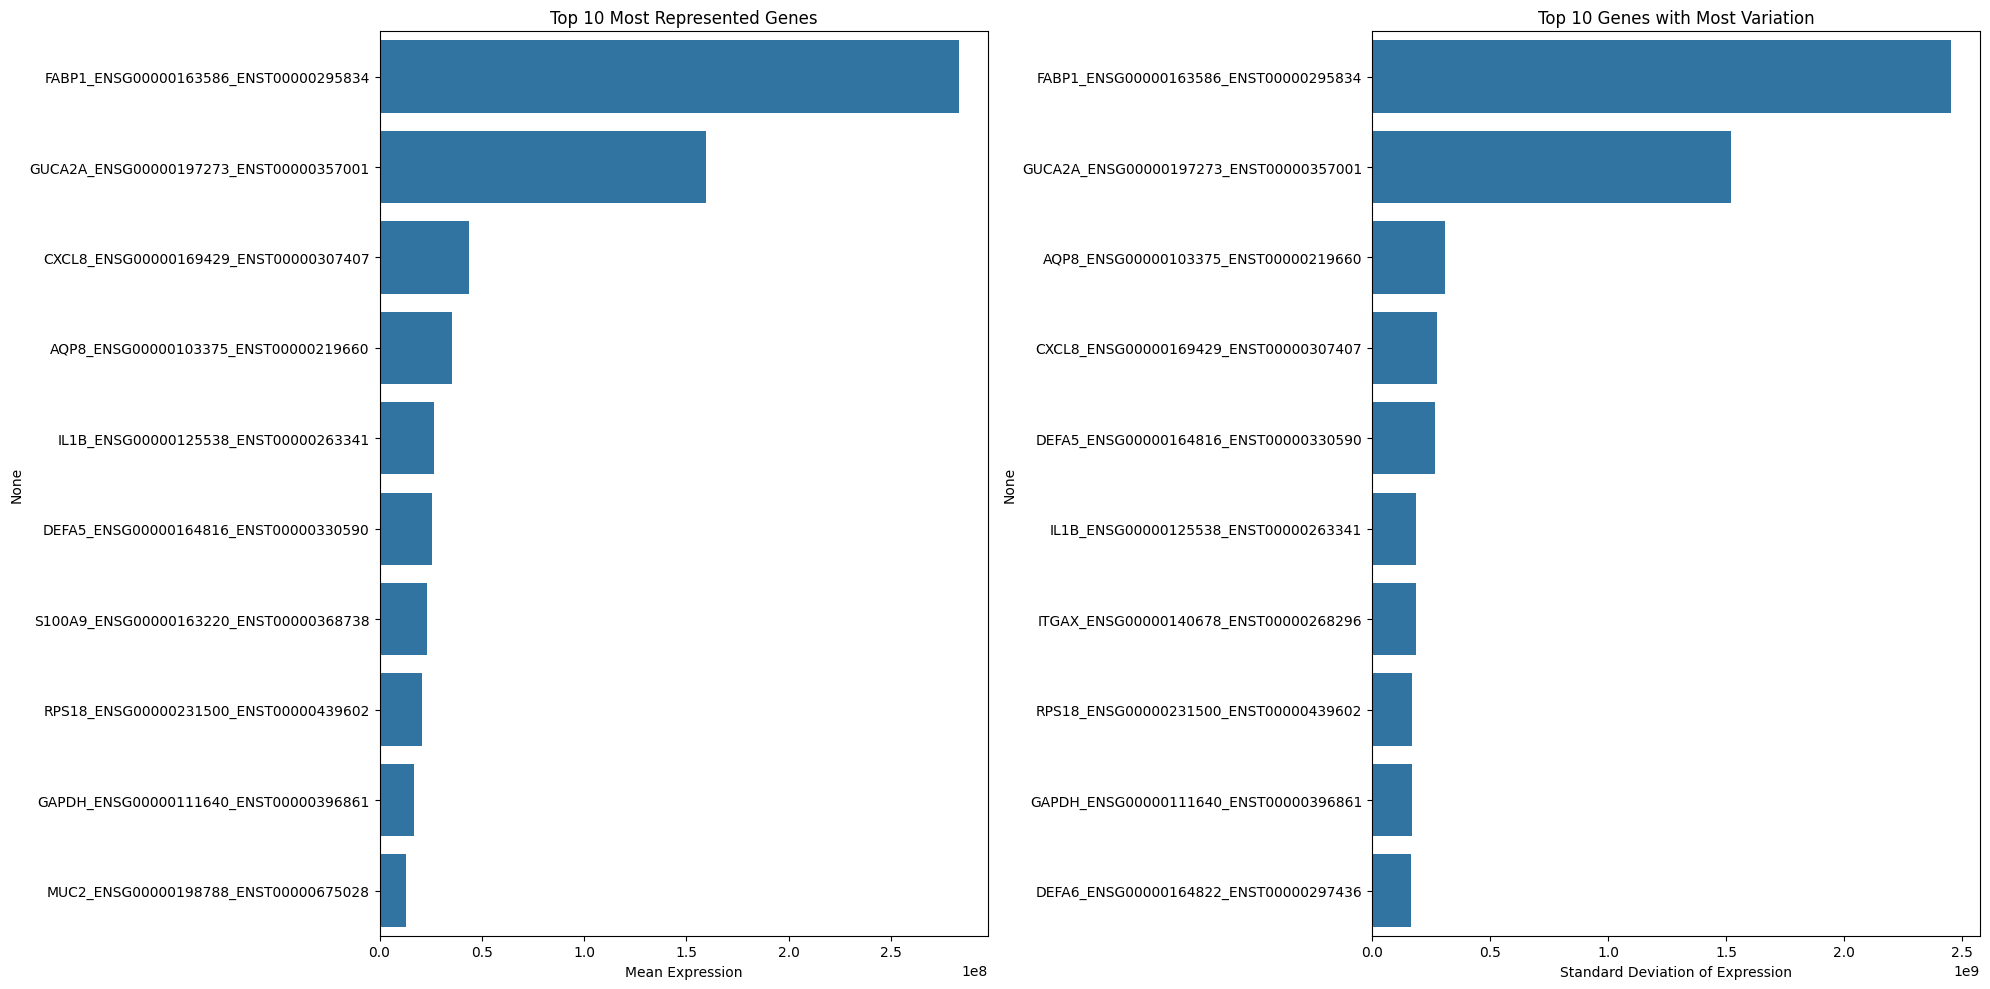

In [ ]:

# Preparing for gene analysis
# Calculate mean and standard deviation for each gene
gene_mean =  gene_count_df.iloc[:, 3:].mean()
gene_std =  gene_count_df.iloc[:, 3:].std()


# Identify the most represented genes (highest mean)
most_represented_genes = gene_mean.sort_values(ascending=False).head(10)

# Identify genes with the most variation (highest standard deviation)
most_variable_genes = gene_std.sort_values(ascending=False).head(10)

# Plotting for genes
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
sns.barplot(x=most_represented_genes.values, y=most_represented_genes.index)
plt.title('Top 10 Most Represented Genes')
plt.xlabel('Mean Expression')

plt.subplot(1, 2, 2)
sns.barplot(x=most_variable_genes.values, y=most_variable_genes.index)
plt.title('Top 10 Genes with Most Variation')
plt.xlabel('Standard Deviation of Expression')

plt.tight_layout()
plt.show()

In [ ]:

# species_cols = [col for col in metaphlan_df.columns if col not in ['patient_id', 'week', 'Flare_status']]

# non_zero_counts = metaphlan_df.groupby('patient_id')[species_cols].apply(lambda x: (x != 0).sum())
# non_zero_counts = non_zero_counts.apply(lambda x: x[x > 0])
# species_count_per_patient = non_zero_counts.count(axis=1)

# # Print the result
# print("Number of species with at least one non-zero value per patient:")
# print(species_count_per_patient)


In [ ]:
# # @title Remove dominant species
# # Step 1: Compute mean relative abundances for each species per patient
# species_columns = [col for col in metaphlan_df.columns if col.startswith('s__')]
# mean_abundances = metaphlan_df.groupby('patient_id')[species_columns].mean()

# # Step 2: Identify species to zero out
# species_to_zero = mean_abundances.apply(lambda x: x > 0.07)

# # Step 3: Set values to zero for identified species
# for patient in species_to_zero.index:
#     for species in species_columns:
#         if species_to_zero.at[patient, species]:
#             metaphlan_df.loc[metaphlan_df['patient_id'] == patient, species] = 0

# # Step 4: Normalize the DataFrame so that each row sums to 1
# metaphlan_df[species_columns] = metaphlan_df[species_columns].div(metaphlan_df[species_columns].sum(axis=1), axis=0)


In [ ]:
most_variable_genes

FABP1_ENSG00000163586_ENST00000295834     2.453581e+09
GUCA2A_ENSG00000197273_ENST00000357001    1.519788e+09
AQP8_ENSG00000103375_ENST00000219660      3.100883e+08
CXCL8_ENSG00000169429_ENST00000307407     2.760873e+08
DEFA5_ENSG00000164816_ENST00000330590     2.669498e+08
IL1B_ENSG00000125538_ENST00000263341      1.857572e+08
ITGAX_ENSG00000140678_ENST00000268296     1.850766e+08
RPS18_ENSG00000231500_ENST00000439602     1.712945e+08
GAPDH_ENSG00000111640_ENST00000396861     1.692603e+08
DEFA6_ENSG00000164822_ENST00000297436     1.632749e+08
dtype: float64

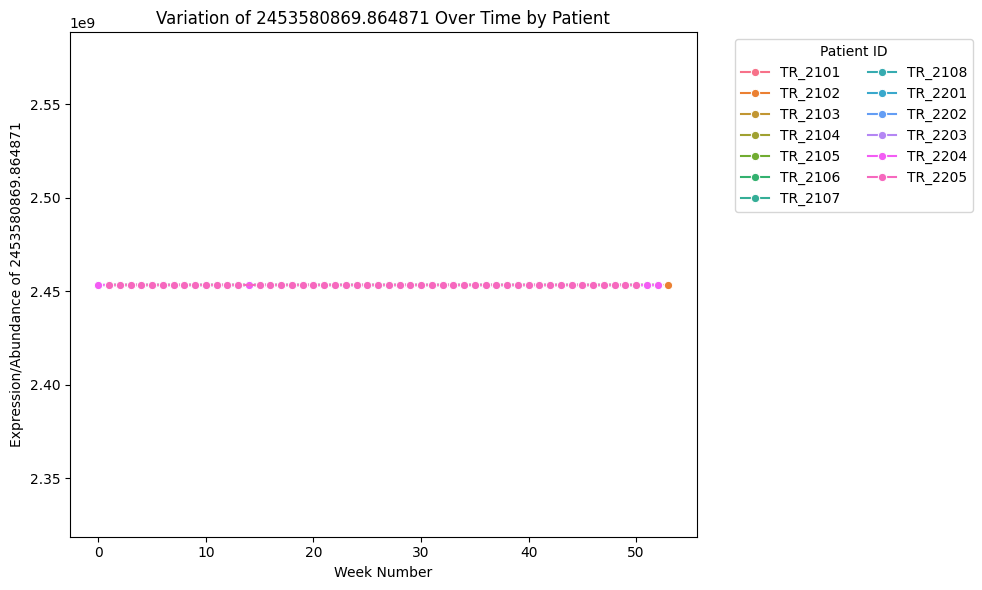

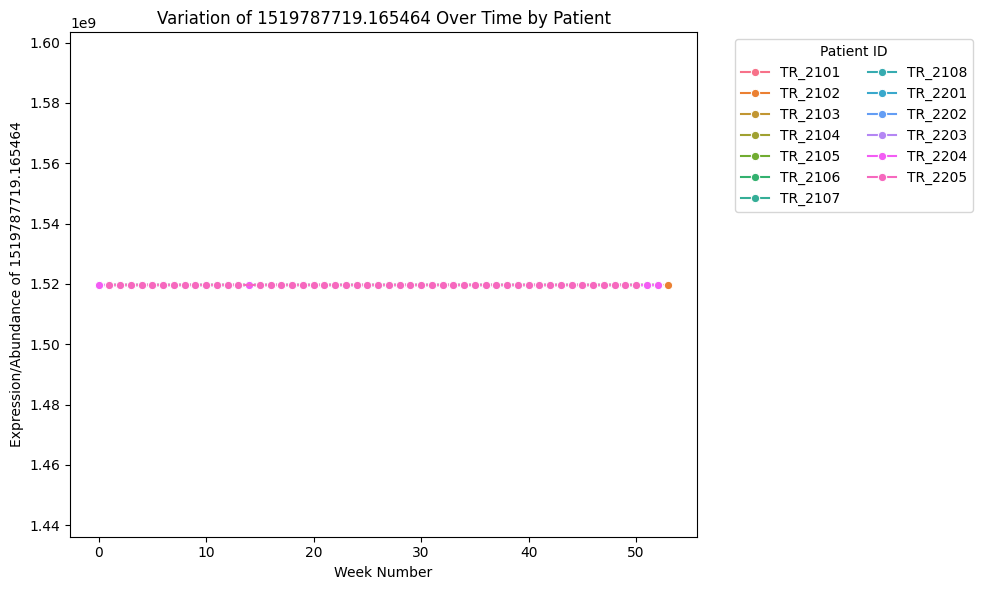

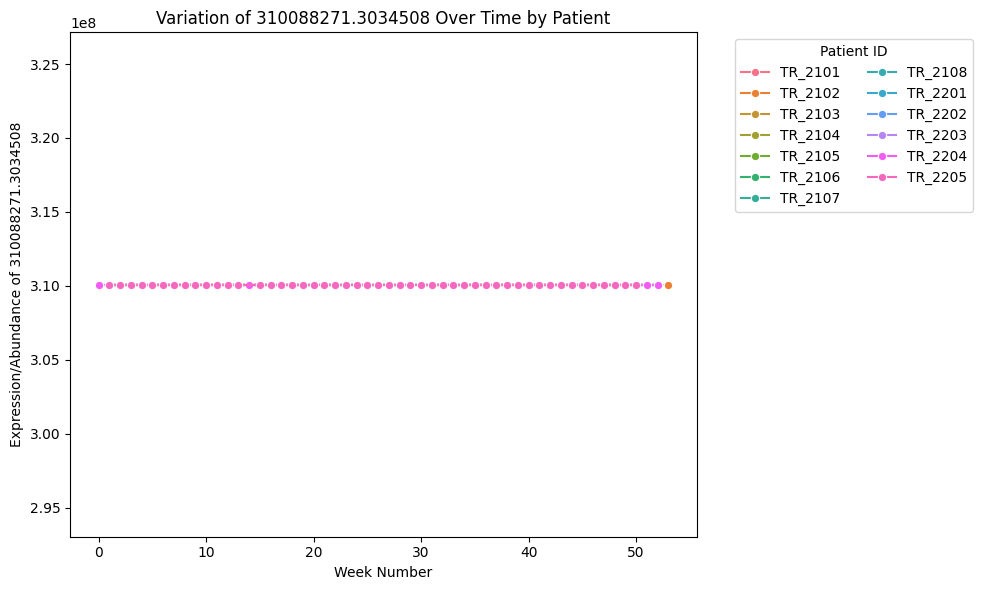

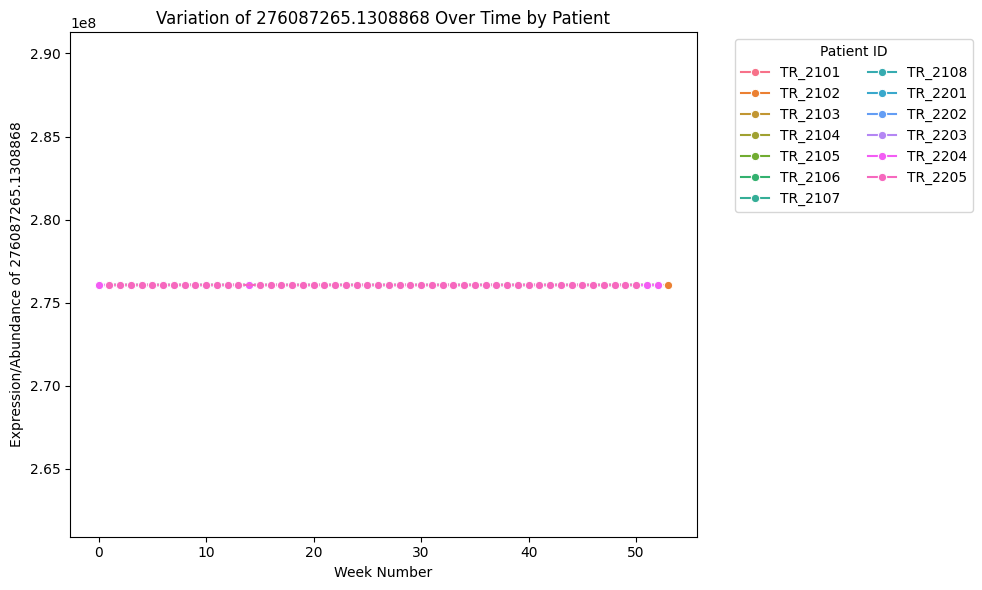

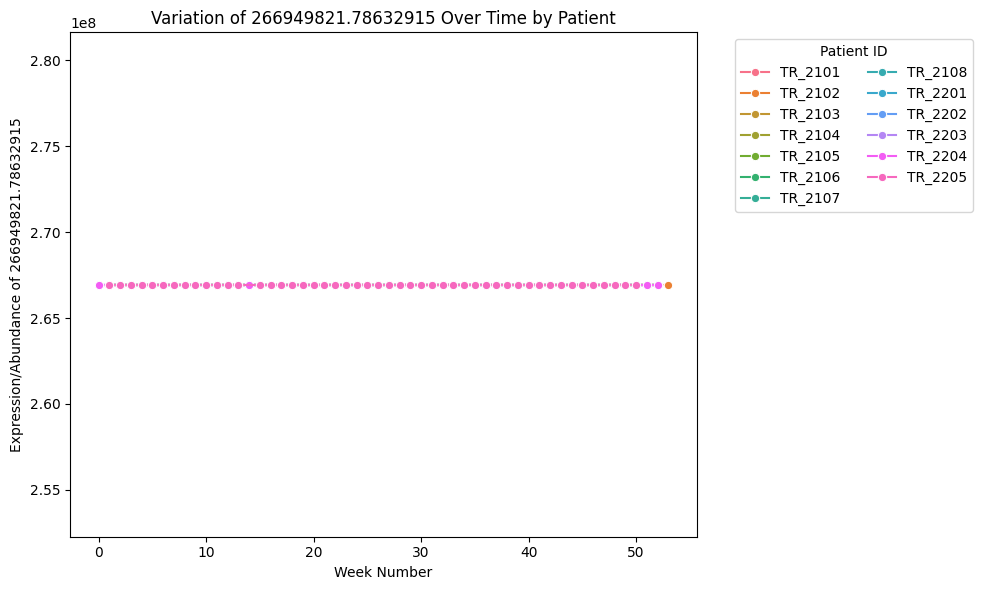

In [ ]:
# @title
def plot_variation_over_time(df, target_columns):
    for target_column in target_columns:
        plt.figure(figsize=(10, 6))
        sns.lineplot(data=df, x='week', y=target_column, hue='patient_id', marker='o', legend="full")
        plt.title(f'Variation of {target_column} Over Time by Patient')
        plt.xlabel('Week Number')
        plt.ylabel(f'Expression/Abundance of {target_column}')
        plt.legend(title='Patient ID', bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2)
        plt.tight_layout()
        plt.show()


most_variable_genes = most_variable_genes[0:5]
#most_variable_bacteria = most_variable_bacteria.index[0:5]

# Example usage for genes
plot_variation_over_time(gene_count_df, most_variable_genes)

# Example usage for bacteria
#plot_variation_over_time(metaphlan_df, most_variable_bacteria)


Patient 2102 had a flair from week 16 to 24
Patient 2101 had a flair from week 25 to 43
Patient 2103 had a flair from week 27 to 39

In [ ]:
# # @title
# for patient in metaphlan_df['patient_id'].unique():
#     patient_data = metaphlan_df[metaphlan_df['patient_id'] == patient].copy()
#     patient_data.sort_values(by='week', inplace=True)  # Ensure data is sorted by week

#     # Exclude non-abundance columns to focus on species data
#     species_data = patient_data.drop(['patient_id', 'week', 'Flare_status'], axis=1)

#     # Find the 10 species with the highest average abundance for the current patient
#     top_species = species_data.mean().sort_values(ascending=False).head(10).index.tolist()

#     plt.figure(figsize=(15, 7))

#     # Plot the abundance over time for the top 10 species
#     for species in top_species:
#         sns.lineplot(data=patient_data, x='week', y=species, label=species)

#     # Annotate flare status changes (if applicable)
#     flare_changes = patient_data.drop_duplicates('Flare_status', keep='first')[['week', 'Flare_status']]
#     for _, (week, status) in flare_changes.iterrows():
#         plt.axvline(x=week, color='grey', linestyle='--')
#         plt.text(week, plt.gca().get_ylim()[1], f' {status}', verticalalignment='top', fontsize=8)

#     # Setting x-axis ticks for every week, adjusting label rotation for clarity
#     plt.xticks(patient_data['week'].unique(), rotation=45)

#     plt.title(f'Top 10 Microbial Abundance Over Time for Patient {patient}')
#     plt.xlabel('Week')
#     plt.ylabel('Abundance')
#     plt.legend(title="Species", bbox_to_anchor=(1.05, 1), loc='upper left')
#     plt.tight_layout()
#     plt.show()


In [ ]:
gene_count_df['patient_id'].drop_duplicates()

In [ ]:
# @title
for patient in gene_count_df['patient_id'].unique():
    patient_data = gene_count_df[gene_count_df['patient_id'] == patient].copy()
    patient_data.sort_values(by='week', inplace=True)  # Ensure data is sorted by week

    # Exclude non-gene expression columns to focus on gene data
    #gene_data = patient_data.drop(['patient_id', 'week', 'Flare_status'], axis=1)
    gene_data = patient_data.drop(['patient_id', 'week'], axis=1)

    # Find the 10 genes with the highest average expression for the current patient
    top_genes = gene_data.mean().sort_values(ascending=False).head(10).index.tolist()

    plt.figure(figsize=(15, 7))

    # Plot the expression over time for the top 10 genes
    for gene in top_genes:
        sns.lineplot(data=patient_data, x='week', y=gene, label=gene)

    # Annotate flare status changes (if applicable)
    #flare_changes = patient_data.drop_duplicates('Flare_status', keep='first')[['week']]
    #for _, (week, status) in flare_changes.iterrows():
     #   plt.axvline(x=week, color='grey', linestyle='--')
      #  plt.text(week, plt.gca().get_ylim()[1], f' {status}', verticalalignment='top', fontsize=8)

    # Setting x-axis ticks for every week, adjusting label rotation for clarity
    plt.xticks(patient_data['week'].unique(), rotation=45)

    plt.title(f'Top 10 Gene Expression Over Time for Patient {patient}')
    plt.xlabel('Week')
    plt.ylabel('Expression Level')
    plt.legend(title="Genes", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# @title
for patient in metaphlan_df['patient_id'].unique():
    patient_data = metaphlan_df[metaphlan_df['patient_id'] == patient].copy()
    patient_data.sort_values(by='week', inplace=True)  # Ensure data is sorted by week

    # Exclude non-abundance columns to focus on species data
    species_data = patient_data.drop(['patient_id', 'week', 'Flare_status'], axis=1)

    # Find the 10 species with the most variation (highest standard deviation) for the current patient
    top_species = species_data.std().sort_values(ascending=False).head(10).index.tolist()

    plt.figure(figsize=(15, 7))

    # Plot the abundance over time for the top 10 species with the most variation
    for species in top_species:
        sns.lineplot(data=patient_data, x='week', y=species, label=species)

    # Annotate flare status changes (if applicable)
    flare_changes = patient_data.drop_duplicates('Flare_status', keep='first')[['week', 'Flare_status']]
    for _, (week, status) in flare_changes.iterrows():
        plt.axvline(x=week, color='grey', linestyle='--')
        plt.text(week, plt.gca().get_ylim()[1], f' {status}', verticalalignment='top', fontsize=8)

    # Setting x-axis ticks for every week, adjusting label rotation for clarity
    plt.xticks(patient_data['week'].unique(), rotation=45)

    plt.title(f'Top 10 Species with Most Variation Over Time for Patient {patient}')
    plt.xlabel('Week')
    plt.ylabel('Abundance')
    plt.legend(title="Species", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


NameError: name 'metaphlan_df' is not defined

In [ ]:
# @title
for patient in gene_count_df['patient_id'].unique():
    patient_data = gene_count_df[gene_count_df['patient_id'] == patient].copy()
    patient_data.sort_values(by='week', inplace=True)  # Ensure data is sorted by week

    # Exclude non-gene expression columns to focus on gene data
    gene_data = patient_data.drop(['patient_id', 'week', 'Flare_status'], axis=1)

    # Find the 10 genes with the most variation (highest standard deviation) for the current patient
    top_genes = gene_data.std().sort_values(ascending=False).head(10).index.tolist()

    plt.figure(figsize=(15, 7))

    # Plot the expression over time for the top 10 genes with the most variation
    for gene in top_genes:
        sns.lineplot(data=patient_data, x='week', y=gene, label=gene)

    # Annotate flare status changes (if applicable)
    flare_changes = patient_data.drop_duplicates('Flare_status', keep='first')[['week', 'Flare_status']]
    for _, (week, status) in flare_changes.iterrows():
        plt.axvline(x=week, color='grey', linestyle='--')
        plt.text(week, plt.gca().get_ylim()[1], f' {status}', verticalalignment='top', fontsize=8)

    # Setting x-axis ticks for every week, adjusting label rotation for clarity
    plt.xticks(patient_data['week'].unique(), rotation=45)

    plt.title(f'Top 10 Genes with Most Variation Over Time for Patient {patient}')
    plt.xlabel('Week')
    plt.ylabel('Expression Level')
    plt.legend(title="Genes", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


In [ ]:
# species to investigate

In [ ]:
# @title
for patient in metaphlan_df['patient_id'].unique():
    patient_data = metaphlan_df[metaphlan_df['patient_id'] == patient].copy()
    patient_data.sort_values(by='week', inplace=True)  # Ensure data is sorted by week

    # Exclude non-abundance columns to focus on species data
    species_data = patient_data.drop(['patient_id', 'week', 'Flare_status'], axis=1)


    plt.figure(figsize=(15, 7))

    # Plot the abundance over time for the top 10 species with the most variation
    for species in  ['s__Phocaeicola_dorei','s__Bacteroides_uniformis','s__Faecalibacterium_prausnitzii' , 's__Bifidobacterium_pullorum',
  's__Bacteroides_ovatus', 's__Clostridia_bacterium', 's__Eubacterium_rectale', 's__Blautia_sp_MSK_21_1',
  's__GGB4569_SGB6310', 's__Blautia_wexlerae']:
        sns.lineplot(data=patient_data, x='week', y=species, label=species)

    # Annotate flare status changes (if applicable)
    flare_changes = patient_data.drop_duplicates('Flare_status', keep='first')[['week', 'Flare_status']]
    for _, (week, status) in flare_changes.iterrows():
        plt.axvline(x=week, color='grey', linestyle='--')
        plt.text(week, plt.gca().get_ylim()[1], f' {status}', verticalalignment='top', fontsize=8)

    # Setting x-axis ticks for every week, adjusting label rotation for clarity
    plt.xticks(patient_data['week'].unique(), rotation=45)

    plt.title(f'Species to investigate for Patient {patient}')
    plt.xlabel('Week')
    plt.ylabel('Abundance')
    plt.legend(title="Species", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


microbes to investigate

In [ ]:
metaphlan_df.filter(regex=r'^s__Blautia').columns

In [ ]:
# @title
for patient in gene_count_df['patient_id'].unique():
    patient_data = gene_count_df[gene_count_df['patient_id'] == patient].copy()
    patient_data.sort_values(by='week', inplace=True)  # Ensure data is sorted by week

    # Exclude non-gene expression columns to focus on gene data
    gene_data = patient_data.drop(['patient_id', 'week', 'Flare_status'], axis=1)

    # Find the 10 genes with the most variation (highest standard deviation) for the current patient
    top_genes = gene_data.std().sort_values(ascending=False).head(10).index.tolist()

    plt.figure(figsize=(15, 7))

    # Plot the expression over time for the top 10 genes with the most variation
    for gene in top_genes:
        sns.lineplot(data=patient_data, x='week', y=gene, label=gene)

    # Annotate flare status changes (if applicable)
    flare_changes = patient_data.drop_duplicates('Flare_status', keep='first')[['week', 'Flare_status']]
    for _, (week, status) in flare_changes.iterrows():
        plt.axvline(x=week, color='grey', linestyle='--')
        plt.text(week, plt.gca().get_ylim()[1], f' {status}', verticalalignment='top', fontsize=8)

    # Setting x-axis ticks for every week, adjusting label rotation for clarity
    plt.xticks(patient_data['week'].unique(), rotation=45)

    plt.title(f'Genes to investigate Over Time for Patient {patient}')
    plt.xlabel('Week')
    plt.ylabel('Expression Level')
    plt.legend(title="Genes", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


In [ ]:
# @title Augmented Dickey-Fuller (ADF) test
def analyze_time_series(data, significance_level=0.05, mht="bonferroni"):
    flare_status="Pre_flare"
    patient_ids = ["TR_2201", "TR_2202"]

    # Suppress runtime warnings from statsmodels or other calculations
    warnings.filterwarnings('ignore', category=RuntimeWarning)

    # Filter the DataFrame safely
    filtered_df = data.copy()[(data['patient_id'].isin(patient_ids)) | (data['Flare_status'] == flare_status)]

    # Modify the patient_id based on the week
    def modify_patient_id(row):
        if row['patient_id'] in patient_ids:
            suffix = "_1" if row['week'] < 25 else "_2"
            return f"{row['patient_id']}{suffix}"
        else:
            return row['patient_id']

    filtered_df['patient_id'] = filtered_df.apply(modify_patient_id, axis=1)

    # Define columns to analyze (excluding metadata columns)
    analyze_columns = [col for col in filtered_df.columns if col not in ['patient_id', 'week', 'Flare_status']]

    # Prepare to store results
    adf_results = []

    # Perform ADF tests
    for patient_id in filtered_df['patient_id'].unique():
        patient_data = filtered_df[filtered_df['patient_id'] == patient_id]
        for column in analyze_columns:
            time_series = patient_data[column]
            if time_series.notna().all() and len(time_series) > 1 and time_series.var() > 0:
                try:
                    result = adfuller(time_series)
                    adf_results.append({
                        'patient_id': patient_id,
                        'variable': column,
                        'ADF Statistic': result[0],
                        'p-value': result[1],
                        'Used lag': result[2],
                        'Number of observations': result[3],
                        'Critical values': result[4],
                        'IC used': result[5]
                    })
                except Exception as e:
                    adf_results.append({
                        'patient_id': patient_id,
                        'variable': column,
                        'Error': str(e)
                    })
            else:
                adf_results.append({
                    'patient_id': patient_id,
                    'variable': column,
                    'Error': 'Insufficient data or variance'
                })

    # Convert results to DataFrame
    results_df = pd.DataFrame(adf_results)
    results_df['p-value'] = pd.to_numeric(results_df['p-value'], errors='coerce')

    # Apply multiple testing corrections
    _, bh_adjusted, _, _ = multipletests(results_df['p-value'].dropna(), method='fdr_bh')
    _, bonf_adjusted, _, _ = multipletests(results_df['p-value'].dropna(), method='bonferroni')

    results_df['bh_adjusted_p-value'] = pd.Series(bh_adjusted, index=results_df['p-value'].dropna().index)
    results_df['bonferroni_adjusted_p-value'] = pd.Series(bonf_adjusted, index=results_df['p-value'].dropna().index)

    # Filter significant results
    if mht == "bonferroni":
      significant_results = results_df[results_df['bonferroni_adjusted_p-value'] < significance_level]
    elif mht == "bh" :
      significant_results = results_df[results_df['bh_adjusted_p-value'] < significance_level]

    # Print results
    significant_counts = significant_results.groupby('patient_id').size()
    print("Summary of significant adjusted p-value counts by patient:")
    print(significant_counts)

    for patient_id, count in significant_counts.items():
        print(f"Patient ID: {patient_id}")
        print(f"Number of variables with significant adjusted p-values: {count}")
        patient_vars = significant_results[significant_results['patient_id'] == patient_id]
        for index, row in patient_vars.iterrows():
          if mht == "bonferroni":
            print(f"  Variable: {row['variable']}, Adjusted p-value: {row['bonferroni_adjusted_p-value']:.5f}")
          elif mht == "bh" :
            print(f"  Variable: {row['variable']}, Adjusted p-value: {row['bh_adjusted_p-value']:.5f}")
        print("\n")  # Add a new line for readability

    target_ids = ['TR_2101', 'TR_2102', 'TR_2103']

     # Find and print variables significant across specific target patient IDs
    target_significant = significant_results[significant_results['patient_id'].isin(target_ids)]
    common_significant_vars = target_significant.groupby('variable').filter(lambda x: len(x) == len(target_ids))

    if not common_significant_vars.empty:
        print("\nVariables significant across all specified target patient IDs:")
        for variable in common_significant_vars['variable'].unique():
            print(f"Variable: {variable}")
            relevant_patients = significant_results[significant_results['variable'] == variable]
            other_patients = relevant_patients[~relevant_patients['patient_id'].isin(target_ids)]
            print(f"Significant in target IDs: {', '.join(target_ids)}")
            if not other_patients.empty:
                print(f"Also significant in other patient IDs: {', '.join(other_patients['patient_id'].unique())}")
            else:
                print("Not significant in any other patient IDs.")
    else:
        print("No variables are significant across all specified target patient IDs.")

    print("\n")  # Add a new line for readability

In [ ]:
analyze_time_series(metaphlan_df, 0.1, "bonferroni")

In [ ]:
analyze_time_series(gene_count_df, 0.1, "bonferroni")

In [ ]:
data= metaphlan_df.copy()
flare_status="Pre_flare"
patient_ids = ["TR_2201", "TR_2202"]

# Suppress runtime warnings from statsmodels or other calculations
warnings.filterwarnings('ignore', category=RuntimeWarning)

# Filter the DataFrame safely
filtered_df = data.copy()[(data['patient_id'].isin(patient_ids)) | (data['Flare_status'] == flare_status)]

# Modify the patient_id based on the week
def modify_patient_id(row):
    if row['patient_id'] in patient_ids:
        suffix = "_1" if row['week'] < 25 else "_2"
        return f"{row['patient_id']}{suffix}"
    else:
        return row['patient_id']

filtered_df['patient_id'] = filtered_df.apply(modify_patient_id, axis=1)


In [ ]:
data[['patient_id','week','Flare_status']][data['week'].isin([24,25])][data['patient_id']=="TR_2101"].sort_values(by="week")

In [ ]:
data[['patient_id','week','Flare_status']][data['week'].isin([14,16])][data['patient_id']=="TR_2102"].sort_values(by="week")

In [ ]:
data[['patient_id','week','Flare_status']][data['week'].isin([25,27])][data['patient_id']=="TR_2103"].sort_values(by="week")

In [ ]:
# @title
def analyze_time_series(data, significance_level=0.05, mht="bonferroni"):
    flare_status="Pre_flare"
    patient_ids = ["TR_2201", "TR_2202"]

    # Suppress runtime warnings from statsmodels or other calculations
    warnings.filterwarnings('ignore', category=RuntimeWarning)

    # Filter the DataFrame safely
    filtered_df = data.copy()[(data['patient_id'].isin(patient_ids)) | (data['Flare_status'] == flare_status)]

    # Modify the patient_id based on the week
    def modify_patient_id(row):
        if row['patient_id'] in patient_ids:
            suffix = "_1" if row['week'] < 25 else "_2"
            return f"{row['patient_id']}{suffix}"
        else:
            return row['patient_id']

    filtered_df['patient_id'] = filtered_df.apply(modify_patient_id, axis=1)

    # Define columns to analyze (excluding metadata columns)
    analyze_columns = [col for col in filtered_df.columns if col not in ['patient_id', 'week', 'Flare_status']]

    # Prepare to store results
    adf_results = []

    # Perform ADF tests
    for patient_id in filtered_df['patient_id'].unique():
        patient_data = filtered_df[filtered_df['patient_id'] == patient_id]
        for column in analyze_columns:
            time_series = patient_data[column]
            if time_series.notna().all() and len(time_series) > 1 and time_series.var() > 0:
                try:
                    result = adfuller(time_series)
                    adf_results.append({
                        'patient_id': patient_id,
                        'variable': column,
                        'ADF Statistic': result[0],
                        'p-value': result[1],
                        'Used lag': result[2],
                        'Number of observations': result[3],
                        'Critical values': result[4],
                        'IC used': result[5]
                    })
                except Exception as e:
                    adf_results.append({
                        'patient_id': patient_id,
                        'variable': column,
                        'Error': str(e)
                    })
            else:
                adf_results.append({
                    'patient_id': patient_id,
                    'variable': column,
                    'Error': 'Insufficient data or variance'
                })

    # Convert results to DataFrame
    results_df = pd.DataFrame(adf_results)
    results_df['p-value'] = pd.to_numeric(results_df['p-value'], errors='coerce')

    # Apply multiple testing corrections
    _, bh_adjusted, _, _ = multipletests(results_df['p-value'].dropna(), method='fdr_bh')
    _, bonf_adjusted, _, _ = multipletests(results_df['p-value'].dropna(), method='bonferroni')

    results_df['bh_adjusted_p-value'] = pd.Series(bh_adjusted, index=results_df['p-value'].dropna().index)
    results_df['bonferroni_adjusted_p-value'] = pd.Series(bonf_adjusted, index=results_df['p-value'].dropna().index)

    # Filter significant results
    if mht == "bonferroni":
      significant_results = results_df[results_df['bonferroni_adjusted_p-value'] < significance_level]
    elif mht == "bh" :
      significant_results = results_df[results_df['bh_adjusted_p-value'] < significance_level]

    # Print results
    significant_counts = significant_results.groupby('patient_id').size()
    print("Summary of significant adjusted p-value counts by patient:")
    print(significant_counts)

    for patient_id, count in significant_counts.items():
        print(f"Patient ID: {patient_id}")
        print(f"Number of variables with significant adjusted p-values: {count}")
        patient_vars = significant_results[significant_results['patient_id'] == patient_id]
        for index, row in patient_vars.iterrows():
          if mht == "bonferroni":
            print(f"  Variable: {row['variable']}, Adjusted p-value: {row['bonferroni_adjusted_p-value']:.5f}")
          elif mht == "bh" :
            print(f"  Variable: {row['variable']}, Adjusted p-value: {row['bh_adjusted_p-value']:.5f}")
        print("\n")  # Add a new line for readability

    target_ids = ['TR_2101', 'TR_2102', 'TR_2103']

     # Find and print variables significant across specific target patient IDs
    target_significant = significant_results[significant_results['patient_id'].isin(target_ids)]
    common_significant_vars = target_significant.groupby('variable').filter(lambda x: len(x) == len(target_ids))

    if not common_significant_vars.empty:
        print("\nVariables significant across all specified target patient IDs:")
        for variable in common_significant_vars['variable'].unique():
            print(f"Variable: {variable}")
            relevant_patients = significant_results[significant_results['variable'] == variable]
            other_patients = relevant_patients[~relevant_patients['patient_id'].isin(target_ids)]
            print(f"Significant in target IDs: {', '.join(target_ids)}")
            if not other_patients.empty:
                print(f"Also significant in other patient IDs: {', '.join(other_patients['patient_id'].unique())}")
            else:
                print("Not significant in any other patient IDs.")
    else:
        print("No variables are significant across all specified target patient IDs.")

    print("\n")  # Add a new line for readability

In [ ]:
gene_count_df[gene_count_df.duplicated()]

In [ ]:
metaphlan_df[metaphlan_df.duplicated()]

In [ ]:
gene_count_df[gene_count_df['week']==15]